In [26]:
import os
#os.environ["OMP_NUM_THREADS"] = "12"   # o número de cores físicos
#os.environ["MKL_NUM_THREADS"] = "12"
import pennylane as qml
from pennylane import numpy as np
from sklearn.svm import SVC
#from pennylane.optimize import AdamOptimizer

In [27]:
#------------------------------------------------
#Creación del kernel cuántico usando parametros entrenados (anteriores)
#------------------------------------------------
def circuito_embedding(params, x, n):
    for p in params:
        #Rotaciones
        for i in range(n):
            qml.Rot(*x, wires=i)
            qml.Rot(*p, wires=i)
        
        #cascada de E (cnots)
        for i in range(n-1): qml.CNOT(wires=[i,i+1]) 

#adjunto
adjunto_empedding=qml.adjoint(circuito_embedding)
n=3
dev3 = qml.device("lightning.qubit", wires=n)
wires = dev3.wires.tolist()

@qml.qnode(dev3,interface='numpy',diff_method=None)
def circuito_kernel(x1,x2, params,n):
    circuito_embedding(params, x1, n)
    adjunto_empedding(params, x2, n)
    return qml.probs(wires=wires)

def kernel(x1, x2, params,n):
    return circuito_kernel(x1, x2, params,n)[0]
learned_params = np.loadtxt("learned_params.txt")

In [28]:
import pandas as pd

X_train = pd.read_csv("X_train.csv").values
X_test = pd.read_csv("X_test.csv").values
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

In [42]:
import matplotlib.pyplot as plt
from pennylane.drawer import MPLDrawer

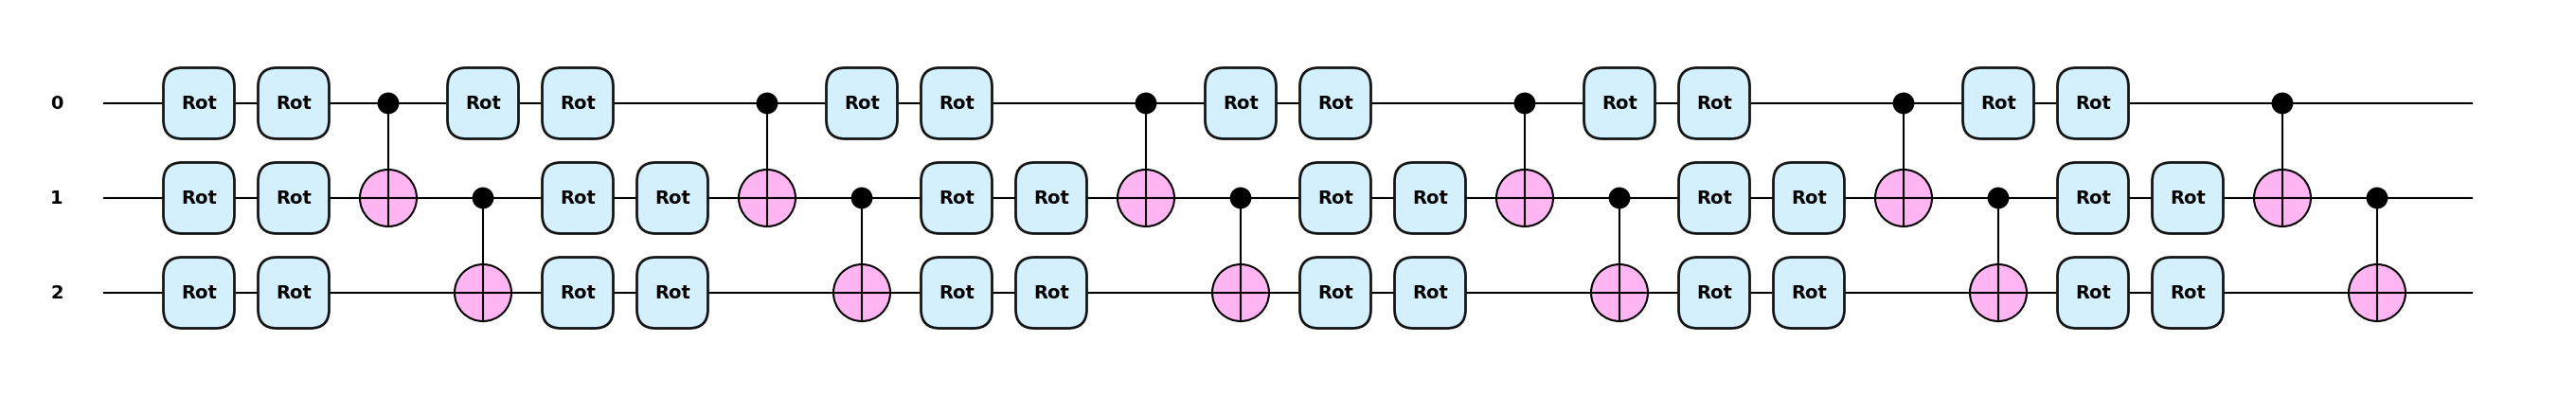

In [45]:
qml.draw_mpl(circuito_embedding, style= 'pennylane' )(learned_params, X_train[0], n)
plt.show()


evaluando

In [10]:
#Probando kernel entre 2 puntos
import time
inicio=time.time()
kernel(X_train[0], X_train[1], learned_params, n)
fin=time.time()
print("Tiempo de kernel entre 2 puntos:",fin-inicio,"segundos")

Tiempo de kernel entre 2 puntos: 0.01853322982788086 segundos


In [11]:

def init_kernel(x1, x2):
    return kernel(x1, x2, learned_params, n)

# contador global
kernel_call_count = {"count": 0}

def counted_init_kernel(x1, x2):
    kernel_call_count["count"] += 1
    if kernel_call_count["count"] % 1000 == 0:
        print(f"Llamada al kernel número: {kernel_call_count['count']}")
        print((kernel_call_count["count"]/3200**2)*100,"% completado")
    return init_kernel(x1, x2)   


In [12]:
K_train = qml.kernels.square_kernel_matrix(X_train, counted_init_kernel)

Llamada al kernel número: 1000
0.009765625 % completado
Llamada al kernel número: 2000
0.01953125 % completado
Llamada al kernel número: 3000
0.029296875 % completado
Llamada al kernel número: 4000
0.0390625 % completado
Llamada al kernel número: 5000
0.048828125 % completado
Llamada al kernel número: 6000
0.05859375 % completado
Llamada al kernel número: 7000
0.068359375 % completado
Llamada al kernel número: 8000
0.078125 % completado
Llamada al kernel número: 9000
0.087890625 % completado
Llamada al kernel número: 10000
0.09765625 % completado
Llamada al kernel número: 11000
0.10742187500000001 % completado
Llamada al kernel número: 12000
0.1171875 % completado
Llamada al kernel número: 13000
0.126953125 % completado
Llamada al kernel número: 14000
0.13671875 % completado
Llamada al kernel número: 15000
0.146484375 % completado
Llamada al kernel número: 16000
0.15625 % completado
Llamada al kernel número: 17000
0.166015625 % completado
Llamada al kernel número: 18000
0.17578125 % co

In [2]:
K_train=np.loadtxt("K_train.csv", delimiter=",")

In [7]:
# 2) Entrenar SVM con kernel precomputado
svm = SVC(kernel="precomputed")
svm.fit(K_train, y_train)

,C,1.0
,kernel,'precomputed'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [8]:
y_pred = svm.predict(K_train)

In [18]:
TP=np.count_nonzero(np.multiply(y_pred, y_train))
TN=len(y_train)-np.count_nonzero(y_pred+y_train)
FN=np.sum((y_pred-y_train)==-1)
FP=np.sum((y_pred-y_train)==1)

In [25]:
TP/(TP+FN), TP/(TP+FP), (TP+TN)/(TP+TN+FP+FN)

(np.float64(0.6708385481852316),
 np.float64(0.7302452316076294),
 np.float64(0.7117849327914973))

In [18]:
# 3) Matriz kernel para test: K_test = K(X_test, X_train)
K_test = qml.kernels.kernel_matrix(X_test, X_train, counted_init_kernel)

# 4) Predicción
y_pred = svm.predict(K_test)

def accuracy(Y_pred, Y_true):
    return 1 - np.count_nonzero(Y_pred - Y_true) / len(Y_true)

nqk_accuracy = accuracy(y_pred, y_test)
print("NQK accuracy:", nqk_accuracy)

Llamada al kernel número: 5119000
49.990234375 % completado
Llamada al kernel número: 5120000
50.0 % completado
Llamada al kernel número: 5121000
50.009765625 % completado
Llamada al kernel número: 5122000
50.01953125000001 % completado
Llamada al kernel número: 5123000
50.02929687499999 % completado
Llamada al kernel número: 5124000
50.0390625 % completado
Llamada al kernel número: 5125000
50.048828125 % completado
Llamada al kernel número: 5126000
50.05859375 % completado
Llamada al kernel número: 5127000
50.06835937500001 % completado
Llamada al kernel número: 5128000
50.07812499999999 % completado
Llamada al kernel número: 5129000
50.087890625 % completado
Llamada al kernel número: 5130000
50.09765625 % completado
Llamada al kernel número: 5131000
50.107421875 % completado
Llamada al kernel número: 5132000
50.11718750000001 % completado
Llamada al kernel número: 5133000
50.12695312499999 % completado
Llamada al kernel número: 5134000
50.13671875 % completado
Llamada al kernel númer

KeyboardInterrupt: 